<a href="https://colab.research.google.com/github/aapokrki/t_xai_project/blob/main/GradCAM_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch GradCAM

PyTorch GradCAM library used: https://github.com/jacobgil/pytorch-grad-cam

In [18]:
!pip install grad-cam;
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import cv2
from PIL import Image
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
from pytorch_grad_cam.utils.image import deprocess_image
from torchvision.transforms.functional import normalize
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import DropInConfidence, IncreaseInConfidence, CamMultImageConfidenceChange



In [19]:
def load_data(batch_size=256, valid_size=0.15, num_workers=0):
   # transformation pipleine from pytorch vgg16 documentation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
    ])

    train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

    # create dataloaders for batching
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader


def test_model(model, test_loader, device, classes, criterion):
  model = model.to(device)

  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval()
  all_results = []

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item() * data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.cpu().numpy())
      # calculate test accuracy for each object class
      for i in range(len(correct)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
          all_results.append((data[i], label, pred))

  # average test loss
  test_loss /= len(test_loader.dataset)
  print(f'Test Loss: {test_loss:.6f}\n')
  for i in range(10):
      if class_total[i] > 0:
          print(f'Test Accuracy of {classes[i]:5s}: {100 * class_correct[i] / class_total[i]:.2f}%')
  overall_acc = 100. * np.sum(class_correct) / np.sum(class_total)
  print(f'Test Accuracy (Overall): {overall_acc:.2f}%')

  return all_results


In [20]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg16_bn", pretrained=True)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [21]:
train_loader, test_loader = load_data(batch_size=256, valid_size=0.15, num_workers=0)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
criterion = nn.CrossEntropyLoss()

# image_results = test_model(model, test_loader, device, classes, criterion)

cpu


In [ ]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Figure plotting functions

In [22]:

# Plots singular rows of images, good for exporting label specific figures
def plot_images_rows(image_list, num_columns=5):
    num_rows = (len(image_list) + num_columns - 1) // num_columns

    for row in range(num_rows):
        fig, axes = plt.subplots(1, num_columns, figsize=(num_columns * 4, 4))
        for col in range(num_columns):
            idx = row * num_columns + col
            if idx < len(image_list):
                true_label, predicted_label, stacked_images, confidence_score, label_color = image_list[idx]
                title = f'True: {classes[true_label]}, Pred: {classes[predicted_label]}'
                if confidence_score is not None:
                    title += f'\nConf Δ: {confidence_score:.3f}%'
                axes[col].imshow(stacked_images)
                axes[col].set_title(title, color=label_color)
                axes[col].axis('off')
            else:
                axes[col].axis('off')
        plt.tight_layout()
        plt.show()

# Plots a single figure of all images. Good for exporting the whole figure
def plot_images_grid(image_list, num_columns=5):
    num_rows = (len(image_list) + num_columns - 1) // num_columns

    fig, axes = plt.subplots(
        num_rows,
        num_columns,
        figsize=(num_columns * 8, num_rows * 4),
        squeeze=False
    )

    axes_flat = axes.flatten()

    for idx in range(len(image_list)):
        true_label, predicted_label, stacked_images, confidence_score, label_color = image_list[idx]
        title = f'True: {classes[true_label]}, Pred: {classes[predicted_label]}'
        if confidence_score is not None:
            title += f'\nConf Δ: {confidence_score:.3f}%'
        axes_flat[idx].imshow(stacked_images)
        axes_flat[idx].set_title(title, color=label_color, fontsize=30)
        axes_flat[idx].axis('off')

    for idx in range(len(image_list), num_rows * num_columns):
        axes_flat[idx].axis('off')

    # Remove gaps between subplots
    plt.subplots_adjust(
        wspace=0.05,
        hspace=0.05
    )
    plt.tight_layout()
    plt.show()



In [23]:
# A confidence delta measurement function (unused in paper but mentioned in the limitations of our method)
# Ultimately cut from the raport due to it not being a focus of our research questions and due to page limit.
def get_cam_confidence_change(input_tensor, grayscale_cam, model, target_category, perturb_most_important):
    grayscale_cam = np.expand_dims(grayscale_cam, axis=0)
    targets = [ClassifierOutputSoftmaxTarget(target_category)]

    perturbed_cam = 1 - grayscale_cam if perturb_most_important else grayscale_cam

    cam_metric = CamMultImageConfidenceChange()
    scores, visualizations = cam_metric(
        input_tensor=input_tensor,
        cams=perturbed_cam,
        targets=targets,
        model=model,
        return_visualization=True
    )

    drop_score = DropInConfidence()(input_tensor, perturbed_cam, targets, model)
    increase_score = IncreaseInConfidence()(input_tensor, perturbed_cam, targets, model)

    # If the score is very low, show label as black
    if abs(scores[0]) < 0.0000099:
        label_color = 'black'
    else:
        if drop_score and perturb_most_important:
            label_color = 'green'
        elif increase_score and not perturb_most_important:
            label_color = 'green'
        else:
            label_color = 'red'

    score = 100 * scores[0]
    vis = visualizations[0].cpu().numpy().transpose(1, 2, 0)
    vis = deprocess_image(vis)
    return score, vis, label_color


Grad-CAM and processing functions

In [24]:

def apply_gradcam(model, input_tensor, target_category, device, target_layers):
    cam = GradCAM(model=model, target_layers=target_layers)
    # input_tensor = image.unsqueeze(0).to(device)

    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_category)])
    grayscale_cam = grayscale_cam[0, :]

    image_np = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    return image_np, grayscale_cam, cam_image

def process_images(model, test_loader, device, target_layers, images_per_label=10,
                   filter_labels=None, perturb_most_important=True, show_metrics=True):

    if not filter_labels:
        filter_labels = list(range(len(classes)))

    label_counts = {i: 0 for i in range(len(classes))}
    all_images = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(images)):
            image = images[i]
            input_tensor = image.unsqueeze(0).to(device)

            true_label = labels[i].item()
            predicted_label = preds[i].item()
            if true_label != predicted_label:
                continue
            if true_label not in filter_labels:
                continue
            if label_counts[true_label] >= images_per_label:
                continue

            img_np, grayscale_cam, cam_image = apply_gradcam(
                model, input_tensor, true_label, device, target_layers)

            if show_metrics:
                confidence_score, perturb_vis, label_color = get_cam_confidence_change(
                    input_tensor, grayscale_cam, model, true_label, perturb_most_important)
                stacked_images = np.hstack((np.uint8(255 * img_np), cam_image, perturb_vis))
            else:
                confidence_score = None
                label_color = 'black'
                stacked_images = np.hstack((np.uint8(255 * img_np), cam_image))

            all_images.append((true_label, predicted_label, stacked_images, confidence_score, label_color))
            label_counts[true_label] += 1

        # ✅ Stop once we’ve collected enough images per label
        if all(label_counts[lbl] >= images_per_label for lbl in filter_labels):
            break

    all_images.sort(key=lambda x: x[0])
    return all_images




Function running cell with changeable variables

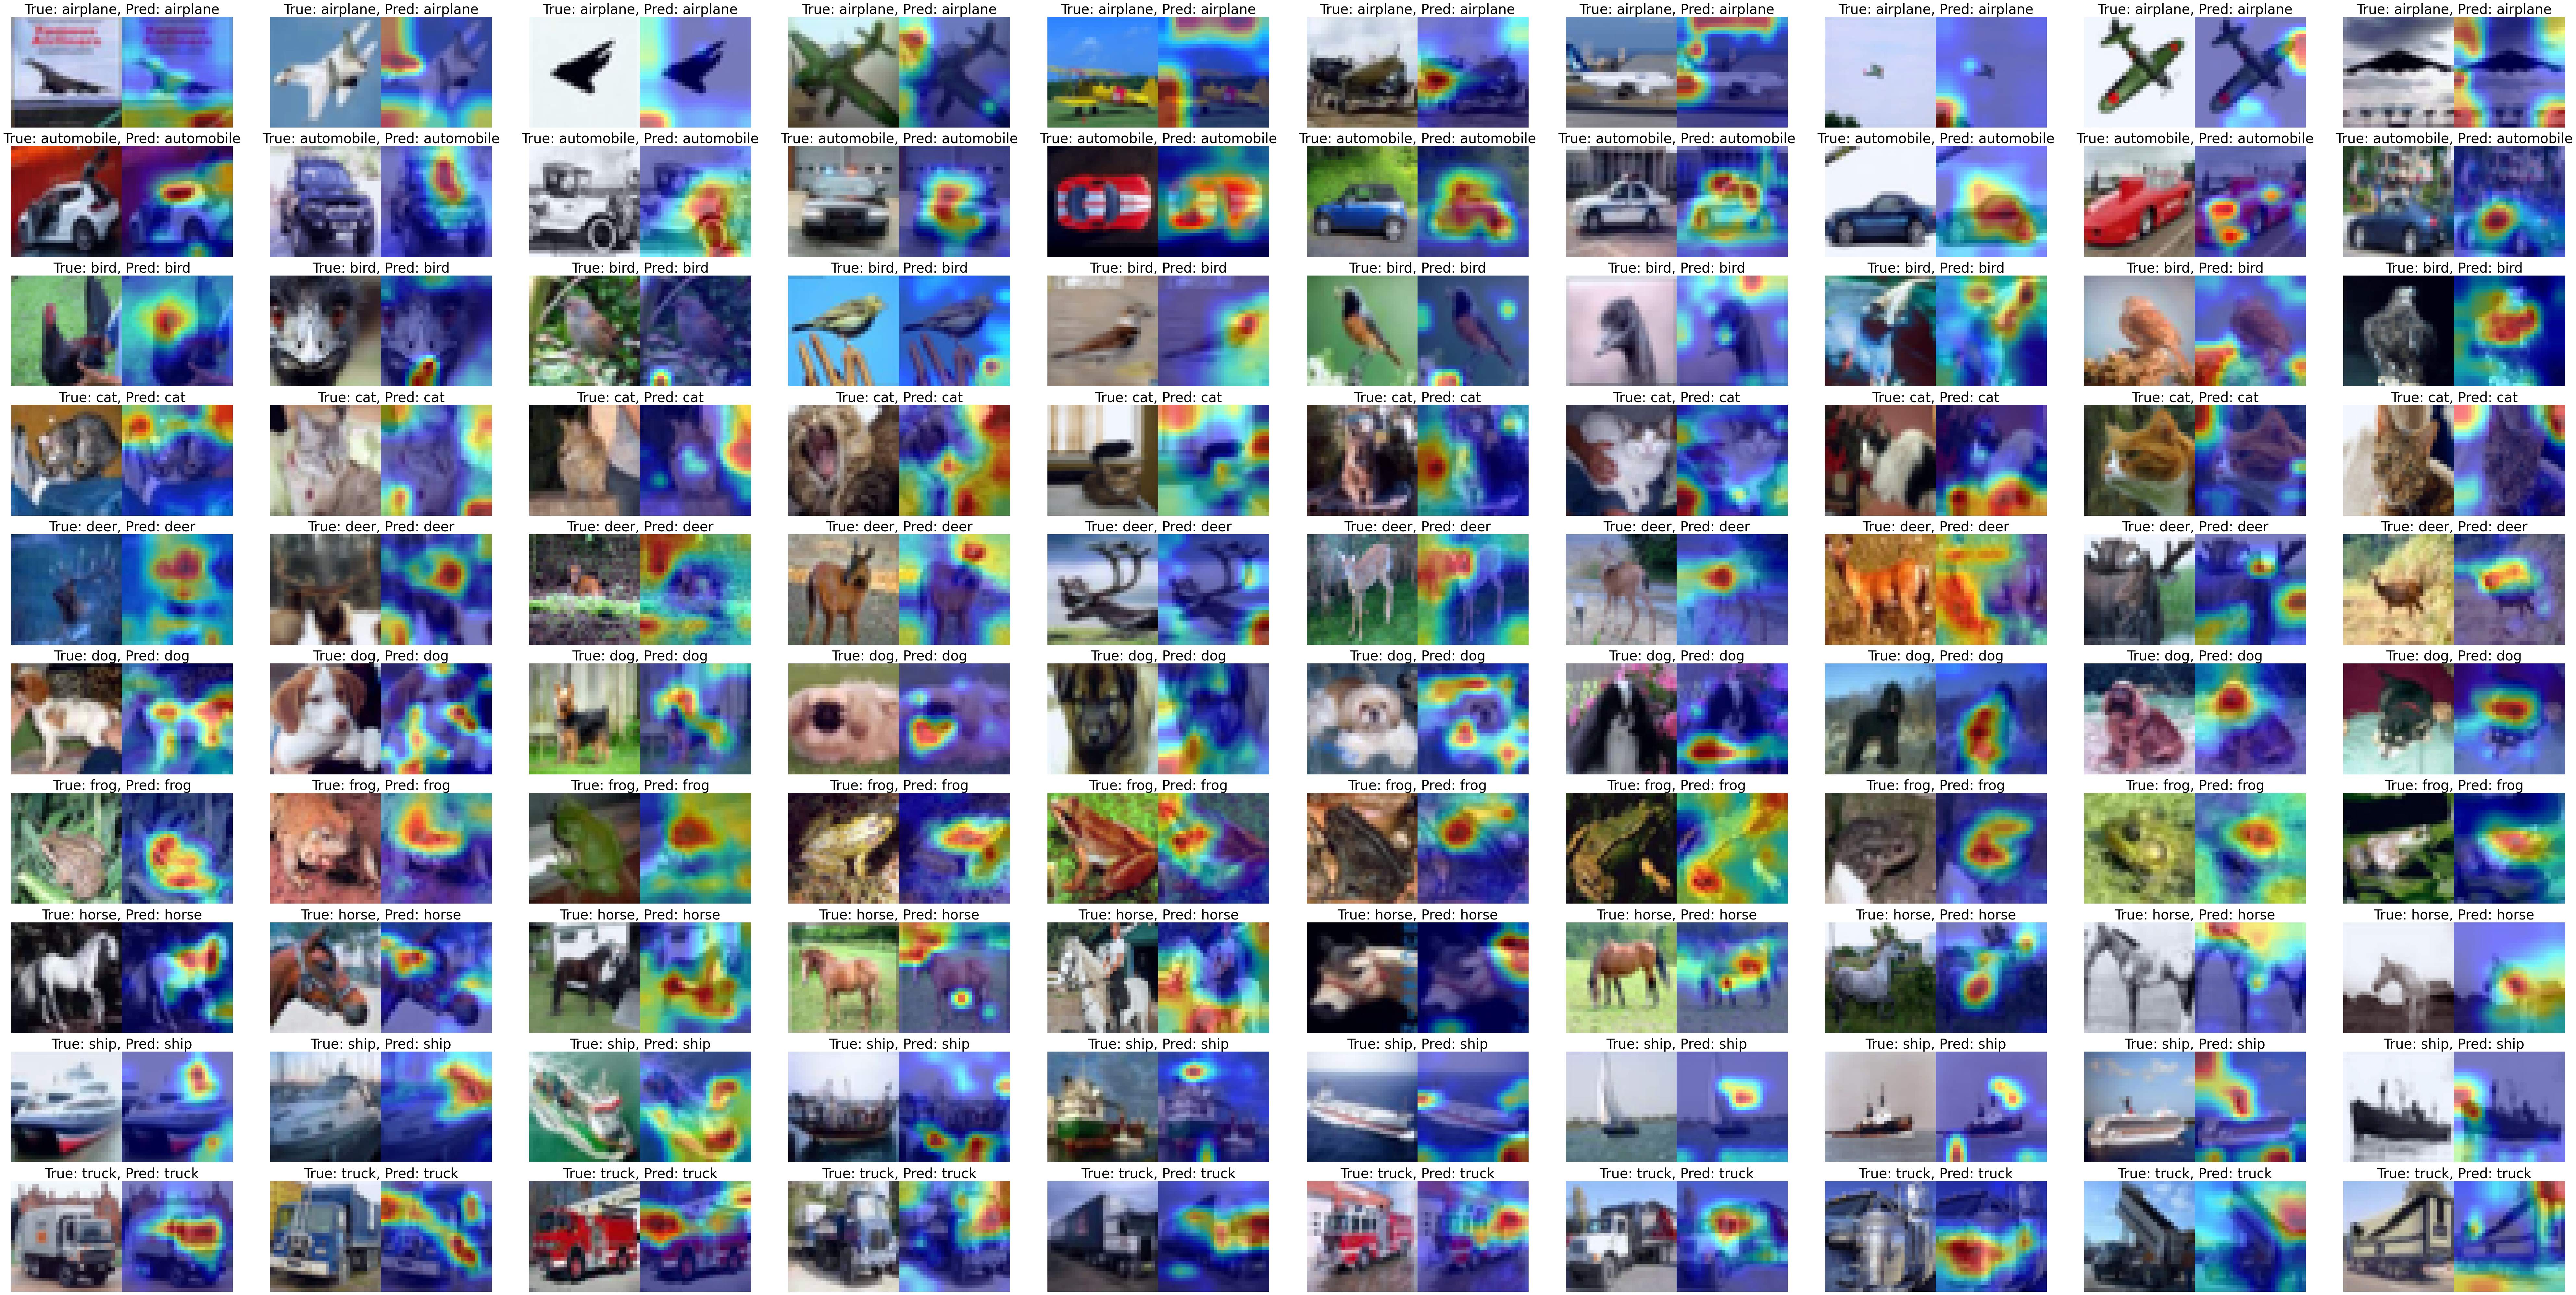

In [26]:

# -------------------------------
# Adjustable parameters
# -------------------------------
target_layers = [model.features[22], model.features[29]] # Set Grad-CAM targer layers | multiple = average of chosen layers
num_columns = 10                    # Set how many columns of images are plotted
images_per_label = 10               # Set how many images per label are shown
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
filter_labels = [] # None for all
# filter_labels = [classes.index("airplane"), classes.index("automobile")]
# filter_labels = [classes.index("dog")] # Set what classes are shown

# Confidence delta metric stuff
perturb_most_important = True       # Set to True to perturb most important areas
show_metrics = False                #Set to False to skip confidence delta metrics

# -------------------------------
# Run
# -------------------------------
image_results = process_images(
    model, test_loader, device,
    target_layers,
    images_per_label,
    filter_labels,
    perturb_most_important,
    show_metrics
)
plot_images_grid(image_results, num_columns=num_columns) #Plots one figure with all rows in one
#plot_images_rows(image_results, num_columns=num_columns) #Plots individual row figures of images with num_columns